# From Raw Steam Reviews to Insight  
Course: **Principles and Techniques in Data Science (2025)**

Pipeline overview:

1. Data collection (web scraping)  
2. Pre‑processing & Exploratory Data Analysis  
3. Clustering (3 methods)  
4. Time‑series forecasting *(or recommender)*  
5. Explainability & fairness  
6. Hyper‑parameter tuning & evaluation  

> Replace placeholders, run each section, and document design choices in extra Markdown cells.

## Data Collection- Steam reviews

**Tools used**  
* Python 3  
* `requests` – HTTP GET & JSON  
* built‑in `time.sleep()` – rate‑limit (0.4 s)  
* built‑in `csv` – incremental write

Endpoint: `https://store.steampowered.com/appreviews/{app_id}`  
Pagination via the `cursor` parameter (100 reviews per call).  
Target volume: ≥ 10 000 rows (3 games × 8 000 reviews each).

In [1]:
import requests, time, csv, pathlib
from datetime import datetime, timezone

DATA_PATH = pathlib.Path("data")
DATA_PATH.mkdir(exist_ok=True)


def fetch_steam_reviews(app_id: int, limit: int = 20_000, delay: float = 0.45):
    url = f"https://store.steampowered.com/appreviews/{app_id}"
    params = {
        "json": 1,
        "num_per_page": 200,
        "filter": "recent",
        "cursor": "*",
        "day_range": "30"  
    }
    rows = []
    while len(rows) < limit:
        j = requests.get(url, params=params, timeout=30).json()
        if j.get("success") != 1 or not j.get("reviews"):
            break

        for r in j["reviews"]:
            review_time = datetime.fromtimestamp(r["timestamp_created"], tz=timezone.utc)
            rows.append({
                "app_id":    app_id,
                "id":        r["recommendationid"],
                "unix_time": r["timestamp_created"],
                "thumbs_up": int(r["voted_up"]),
                "minutes_played": r["author"]["playtime_forever"],
                "useful_score": r["weighted_vote_score"],
                "text":      r["review"].replace("\r", " ").replace("\n", " ").strip(),
            })
            if len(rows) >= limit:
                break

        params["cursor"] = j["cursor"]
        time.sleep(delay)

    return rows

# Game list and scrape
APP_IDS = [730, 570, 578080]  # CS2, Dota 2, PUBG
LIMIT = 14_000

rows = []
for app in APP_IDS:
    print("Scraping", app)
    rows.extend(fetch_steam_reviews(app, LIMIT))

# Save as CSV
print("Total rows:", len(rows))
csv_path = DATA_PATH / "reviews.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader()
    w.writerows(rows)

print("Saved to:", csv_path)


Scraping 730
Scraping 570
Scraping 578080
Total rows: 34089
Saved to: data\reviews.csv


## 1 Pre‑processing & Exploratory Data Analysis

In [2]:

import pandas as pd, matplotlib.pyplot as plt, numpy as np
df = pd.read_csv("data/reviews.csv")
df['dt']    = pd.to_datetime(df['unix_time'], unit='s', utc=True)
df['len']   = df['text'].str.len()
df = df[(df['len'] >= 8)].drop_duplicates('id') # מוריד חוות דעת ריקות ממלל
df = df.drop_duplicates('text')
print("Clean rows:", len(df))

print(df.isnull().sum()) # בדיקה האם נשארו ערכי נאל.
print(df.describe())


Clean rows: 22651
app_id            0
id                0
unix_time         0
thumbs_up         0
minutes_played    0
useful_score      0
text              0
dt                0
len               0
dtype: int64
              app_id            id     unix_time     thumbs_up  \
count   22651.000000  2.265100e+04  2.265100e+04  22651.000000   
mean   246441.026886  1.519885e+08  1.687037e+09      0.705399   
std    285494.371126  5.740725e+07  9.175500e+07      0.455873   
min       570.000000  2.957286e+06  1.349013e+09      0.000000   
25%       730.000000  1.447529e+08  1.692657e+09      0.000000   
50%       730.000000  1.768525e+08  1.728684e+09      1.000000   
75%    578080.000000  1.916795e+08  1.743458e+09      1.000000   
max    578080.000000  1.934786e+08  1.745501e+09      1.000000   

       minutes_played  useful_score           len  
count    2.265100e+04  22651.000000  22651.000000  
mean     6.950197e+04      0.503910    115.048121  
std      1.191634e+05      0.023024   

#### **So What we know about our data so far?** 
* "thumbs_up" says if the user that left the review liked (1) or disliked (0) the game. <br> 
* As you can see, "thumbs_up" mean is 0.73 - which means that **73% of the users tend to like the games**. <br> 
* Most of "useful_score" scores are exactly 0.5 - which says that mos of them are neutral (no up/down votes).

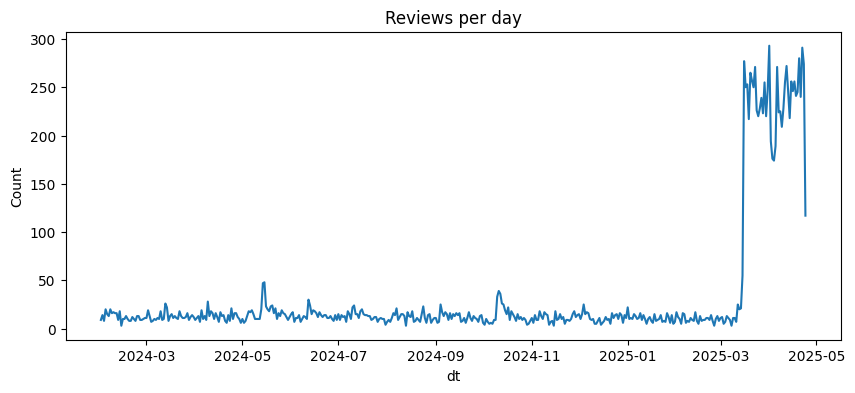

In [3]:
df_recent = df[df["dt"] >= "2024-02-01"] #(3 months back)
df_recent.groupby(df_recent["dt"].dt.date)["id"].count().plot(figsize=(10,4), title="Reviews per day")
plt.ylabel("Count")
plt.show()
# Simple EDA plot

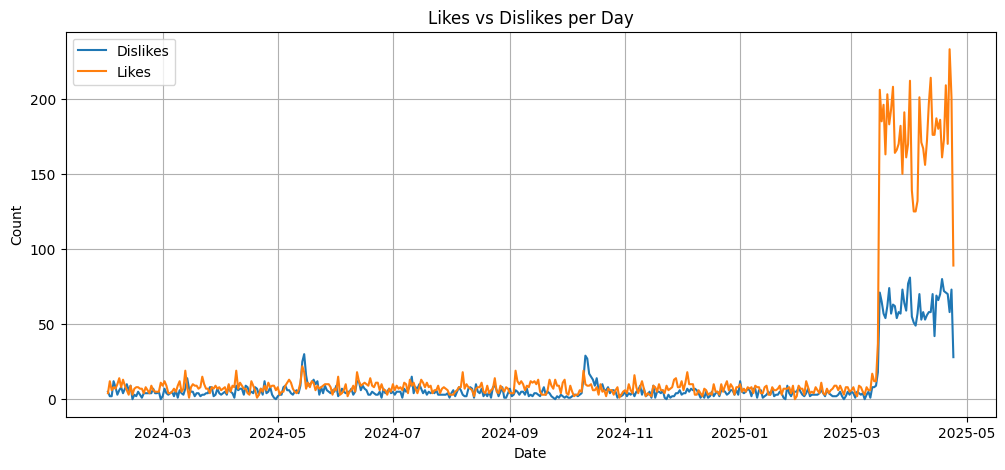

In [4]:
# Step 1: Grouping by day and label
df_recent = df[df["dt"] >= "2024-02-01"] # taking only recent relevant dates (3 months back)
daily_counts = df.groupby([df_recent["dt"].dt.date, "thumbs_up"]).size().unstack(fill_value=0)

# Step 2: Rename columns for clarity
daily_counts.columns = ["Dislikes", "Likes"]  # because 0 = dislike, 1 = like

# Step 3: Plot
daily_counts.plot(kind="line", figsize=(12, 5), title="Likes vs Dislikes per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.show()


#### As you can see, most of the reviews are from the recent month.
#### It is probably due to steam's **truncated historical data** — the kind you get when Steam limits review scraping to recent posts by default..
### Let's zoom in to data between the dates of september to november (2024):

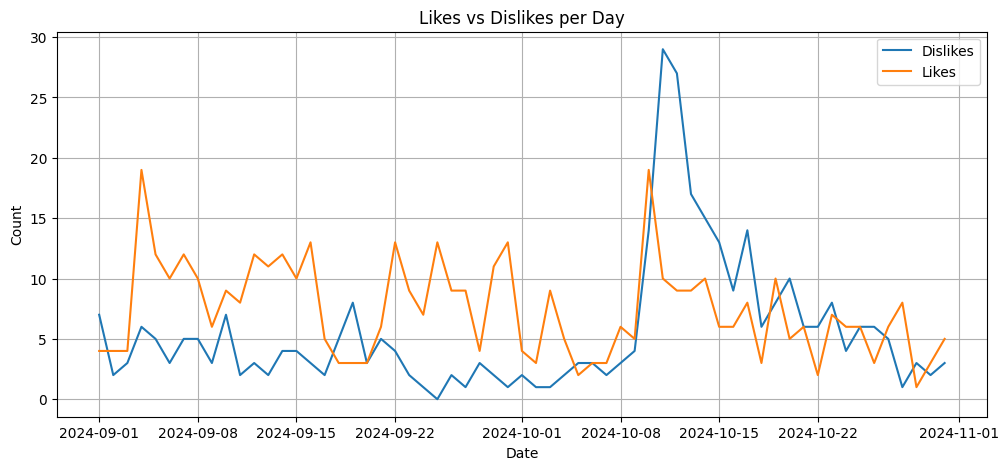

In [5]:

# Step 1: Grouping by day and label
df_recent = df[(df["dt"] >= "2024-09-01") & (df["dt"] <= "2024-11-01")] # taking only recent relevant dates (3 months back)
daily_counts = df.groupby([df_recent["dt"].dt.date, "thumbs_up"]).size().unstack(fill_value=0)

# Step 3: Rename columns for clarity
daily_counts.columns = ["Dislikes", "Likes"]  # because 0 = dislike, 1 = like

# Step 4: Plot
daily_counts.plot(kind="line", figsize=(12, 5), title="Likes vs Dislikes per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.show()


### So after we "dived-in" into the area of this timezone: <br>We can see that between 10.08 to 10.15 there is a "strange" change - there was more dislikes than likes.

#### Trying to explain this behavior, after searching the web we **found out** that: <br> ​"The surge in negative reviews between October 8 and October 15, 2025, for Dota 2, Counter-Strike 2 (CS2), and PUBG appears to be linked to a **combination of in-game updates** and community reactions during that period."

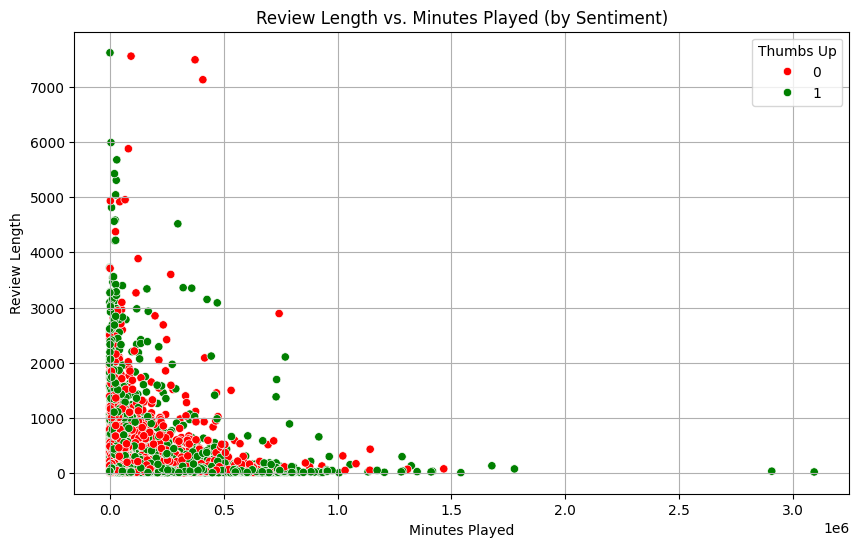

In [7]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.scatterplot(x="minutes_played", y="len", hue="thumbs_up", data=df, palette=["red", "green"])
plt.title("Review Length vs. Minutes Played (by Sentiment)")
plt.xlabel("Minutes Played")
plt.ylabel("Review Length")
plt.grid(True)
plt.legend(title="Thumbs Up")
plt.show()


- Players with very little time can write very long reviews (often complaints or strong reactions).
- High-hour players tend to write shorter reviews, possibly due to familiarity or fatigue.
- Long playtime does not always correlate with positive sentiment — many thumbs-down reviews exist even at 5000+ hours.
- Most reviews are short (~0–500 chars), regardless of hours played.
- The distribution suggests that vocal reviews come from all types of users — not just veterans or fans.

🔻 The more someone plays, the shorter their review tends to be <br>
There’s a visible downward density slope:

As minutes_played increases, len mostly shrinks toward 0–500 chars.

Veteran players might leave short but confident reviews (“GG” (good game in short), “trash”, “CS2 = broken”).

## 3 Clustering – K‑Means, Agglomerative, DBSCAN

In [ ]:
#pip install -U sentence-transformers 
#pip install hf_xet
#these librarys will help us determine which are positive or negetive reviews :)

In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Embed each review into a 384-dim vector using MiniLM
model = SentenceTransformer('all-MiniLM-L6-v2')
df['text'] = df['text'].astype(str)  # force text column to be strings
df = df.reset_index(drop=True)  # fix index misalignment

X_embed = model.encode(df['text'], show_progress_bar=True)

c:\Users\Liorke\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 708/708 [02:48<00:00,  4.21it/s]


"model = SentenceTransformer('all-MiniLM-L6-v2')" <br>
That’s a tiny but powerful neural network trained by huggingface + Microsoft, designed to turn entire sentences into meaningful numeric vectors.

Unlike TF-IDF, it understands:

* grammar
* negation ("not bad game" != "bad game")
* sarcasm

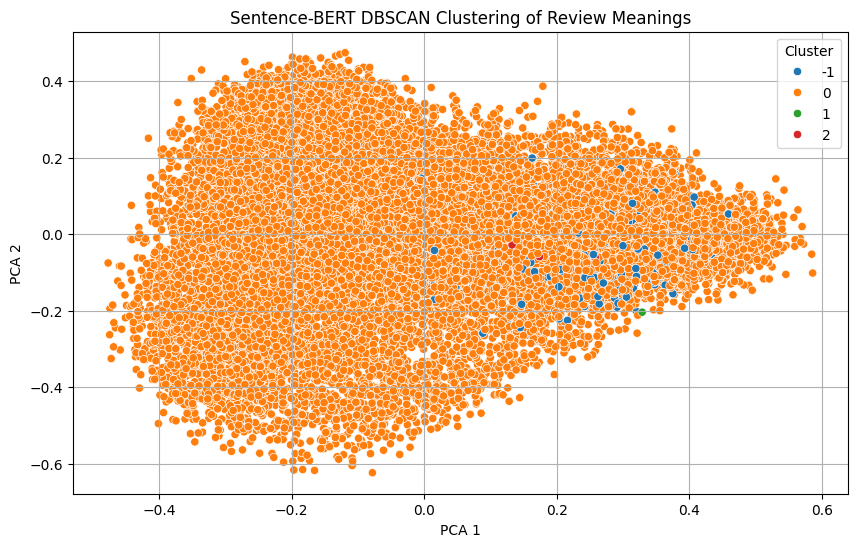


--- Cluster 0 sample reviews ---
                                     game good oke
Love this BR always have, its always great to c...
fucking shit game, only play if have no job or ...

--- Cluster 1 sample reviews ---
                            bring back cobblestone
                       PLEASE ADD CACHE AND COBBLE
Cobblestone is more dead than Lily Potter. It w...

--- Cluster 2 sample reviews ---
If you're looking for a review on this game you...
Let me get this straight, you want me to tell y...
Good game lmao  there you have recipe for brown...


In [17]:
# Step 2: Clustering using DBSCAN
dbscan = DBSCAN(eps=1.05, min_samples=5, metric='euclidean')  # can tweak eps
df['Cluster'] = dbscan.fit_predict(X_embed)

# Step 3: Reducing dimensions for visualization
X_pca = PCA(n_components=2).fit_transform(X_embed)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Step 4: Ploting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='Cluster', data=df, palette='tab10')
plt.title('Sentence-BERT DBSCAN Clustering of Review Meanings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Step 5: Printing 3 example reviews per cluster
for label in sorted(df['Cluster'].unique()):
    if label == -1:
        continue  # skip noise
    print(f"\n--- Cluster {label} sample reviews ---")
    print(df[df['Cluster'] == label]['text'].sample(3, random_state=42).to_string(index=False))

<style>
.cluster-section {
  font-family: 'Segoe UI', sans-serif;
}
.cluster-card {
  background:rgb(255, 255, 255);
  border-left: 6px solid #4f46e5;
  border-radius: 10px;
  padding: 1em 1.5em;
  margin: 1.5em 0;
  box-shadow: 0 1px 6px rgba(0,0,0,0.06);
}
.cluster-card h3 {
  margin-top: 0;
  color:rgb(0, 0, 0);
  font-weight: 500;  
}
.cluster-card p {
  margin-top: 0;
  color:rgb(0, 0, 0);
  font-weight: 500;
}
.cluster-card ul li {
  color:rgb(0, 0, 0); 
  font-weight: 500;
}
.cluster-card.yellow { border-color: #eab308; }
.cluster-card.green { border-color: #22c55e; }
.cluster-card.red { border-color: #ef4444; }
</style>

<div class="cluster-section">

<div class="cluster-card yellow">
  <h3>🟡 Cluster 0: Normal Complaints / Positive Comments</h3>
  <p>
    This one is a mixed bag of regular human reviews:
    <ul>
      <li>"cheaters"</li>
      <li>"best competitive shooter"</li>
      <li>"fun but hackers"</li>
      <li>"nice game"</li>
    </ul>
    <p> → These are generic Steam review people. Mixed tones. Real sentences. </P>
  </p>
</div>

<div class="cluster-card green">
  <h3>🟢 Cluster 1: “WHERE’S COBBLESTONE???”</h3>
  <p>
    All reviews are:
    <ul>
      <li>short</li>
      <li>specific</li>
      <li>fanboys screaming about a missing game mode</li>
    </ul>
    <p> That’s <strong>legit semantic clustering</strong>. We found a niche topic group of angry “Cobblestone” fans </p>
  </p>
</div>

<div class="cluster-card red">
  <h3>🔴 Cluster 2: Spam- "here's a recipe"/ Story telling Bots or Memes</h3>
  <p>
    Every entry is:
    <ul>
      <li>“Here's a recipe for..”</li>
      <li>"Let me get this straight..."</li>
      <li>probably meme-spam or fake reviews</li>
    </ul>
   <p> BERT correctly grouped meme-patterned garbage into one cluster.<br>
    <em>A win for semantic understanding over keywords in our clustering.</em></p>
  </p>
</div>

</div>


## Kmeans

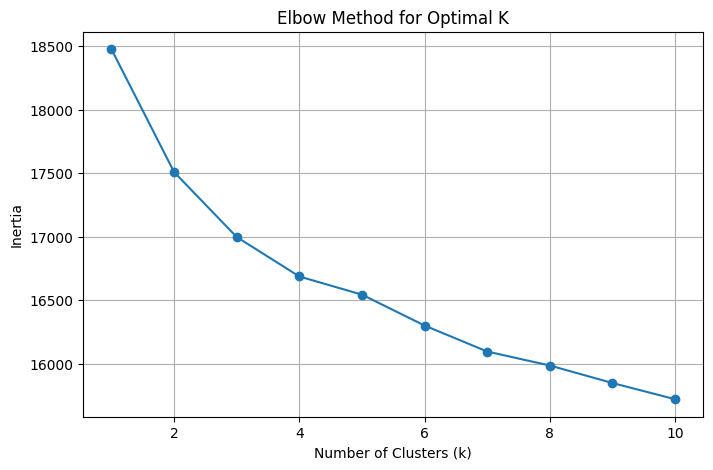

In [18]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Step 1: BERT
X = X_embed

# Step 2: Elbow method - compute inertia for a range of cluster counts
inertias = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X)
    inertias.append(km.inertia_)

# Step 3: Plot elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

<style>
.elbow-box {
  background-color: #f0fdf4;
  border-left: 6px solid #22c55e;
  padding: 1.2em 1.5em;
  margin: 1.5em 0;
  color: black;
  border-radius: 10px;
  font-family: 'Segoe UI', sans-serif;
  box-shadow: 0 2px 6px rgba(255, 250, 250, 0.05);
}
.elbow-title {
  font-weight: bold;
  font-size: 1.3em;
  color: #15803d;
  margin-bottom: 0.6em;
}
.elbow-point {
  margin-bottom: 0.6em;
  line-height: 1.6;
}
</style>

<div class="elbow-box">
  <div class="elbow-title">📈 Why the Elbow Suggests 4 Clusters</div>

  <div class="elbow-point">
    The <strong>Elbow Method</strong> helps determine the optimal number of clusters by plotting the <br> number of clusters (<code>k</code>) against the total within-cluster sum of squares (inertia). <br>
  </div>

  <div class="elbow-point">
    As <code>k</code> increases, inertia decreases — but the goal is to find the point where the rate of decrease sharply slows down — forming an "elbow" shape. <br>
  </div>

  <div class="elbow-point">
    In our plot, the elbow appears around <strong><code>k = 4</code></strong>. Before this point, adding clusters significantly reduces inertia. <br> After <code>k = 4</code>, the improvement becomes minimal and more gradual.
  </div>

  <div class="elbow-point">
    <strong>Conclusion:</strong> The plot shows a clear inflection point at <strong>4 clusters</strong>, making it the optimal choice for K-Means clustering based on the Elbow Method.
  </div>
</div>

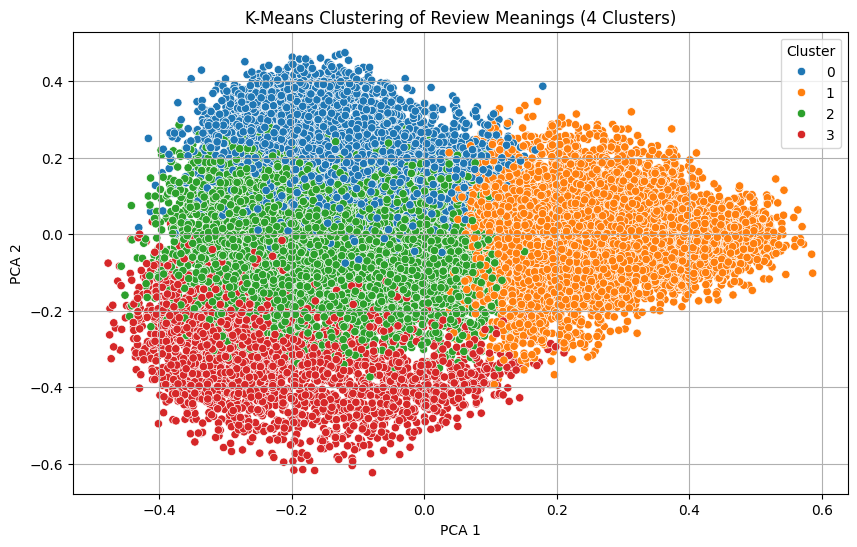


--- K-Means Cluster 0 ---
  Very Nice game if you want to train for marathon
                                      good game :3
this game will make you world heavy weight cham...

--- K-Means Cluster 1 ---
                                         GEWD GAEM
⠄⠂⠄⠐⠄⠄⠄⠄⠄⢀⣠⣶⣶⣿⣿⣿⣷⣶⣶⣤⣀⡀⠄⠄⠄⠄⠄⠄⠂⠄⠐⠄⠄⠂⠄⠐ ⠄⠐⠈⠄⠄⠄⠄⣀⣴⣿...
                                   为什么在大厅里没有开始游戏显示

--- K-Means Cluster 2 ---
Why better when it first came out now it's utte...
2k hours and I still can't play this game... lo...
A great game. There a very real pace that incre...

--- K-Means Cluster 3 ---
Hacking remains a substantial issue. Sadly this...
Cheaters everywhere. using  macros and KRAFTON ...
Hackers running wild on this game, have seen te...


In [ ]:
# Appling K-Means clustering
kmeans = KMeans(n_clusters=4)
df['KMeans_Cluster'] = kmeans.fit_predict(X_embed)

# Reducing dimensions for visualization (optional but helpful)
X_pca = PCA(n_components=2).fit_transform(X_embed)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Ploting clusters in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='KMeans_Cluster', data=df, palette='tab10')
plt.title("K-Means Clustering of Review Meanings (4 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# Showing sample reviews from each cluster
for c in sorted(df['KMeans_Cluster'].unique()):
    print(f"\n--- K-Means Cluster {c} ---")
    print(df[df['KMeans_Cluster'] == c]['text'].sample(3).to_string(index=False))

- 🟦 Cluster 0: Positive + humorous reviews focused on effort, endurance, or light praise.
- 🟧 Cluster 1: Meme-styled reviews, emoji spam, foreign language reviews — grouped by format, not content.
- 🟩 Cluster 2: Long-time players with nuanced criticism — focus on evolution of game quality or frustration after many hours.
- 🟥 Cluster 3: Complaint cluster about cheaters, hackers, and exploiters — high anger signal, very focused.


## Agglomerative Clustering
## First, let's plot the Dendrogram to allow us decide on the clusters' number

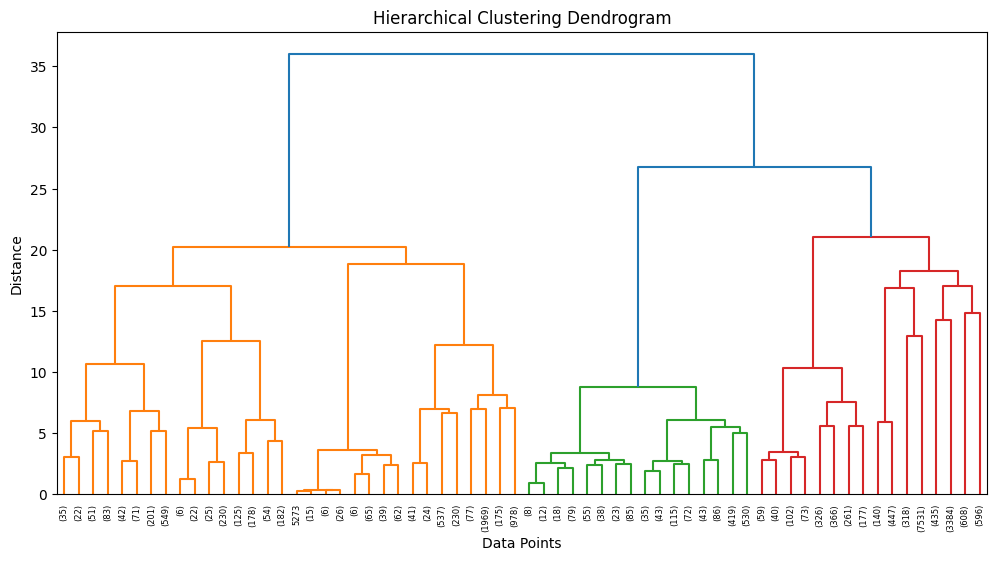

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(X_embed, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

<style>
.dendro-explainer {
  background-color: #f9fafb;
  border-left: 6px solidrgb(70, 118, 229);
  padding: 1.2em;
  border-radius: 10px;
  margin: 1.5em 0;
  font-family: 'Segoe UI', sans-serif;
  box-shadow: 0 2px 5px rgba(0,0,0,0.05);
}
.dendro-title {
  font-weight: bold;
  font-size: 1.3em;
  color:rgb(70, 131, 229);
  margin-bottom: 0.6em;
}
.dendro-point {
  margin-bottom: 0.6em;
  line-height: 1.6;
  color: black;
}
</style>

<div class="dendro-explainer">
  <div class="dendro-title"> Why the Optimal Number of Clusters is 3?</div>

  <div class="dendro-point">
    In hierarchical (agglomerative) clustering, the dendrogram shows how data points are merged step-by-step. <br>
    To determine the best number of clusters, we look for the <strong>largest vertical distance</strong> between two horizontal lines — <br>
    this represents a big jump in dissimilarity when merging clusters.<br>
  </div>

  <div class="dendro-point">
    In our dendrogram, the <strong>largest vertical jump </strong> occurs at the <strong>top</strong> of the tree. <br>
    Cutting just below this point splits the tree into <strong>3 main branches</strong>.
  </div>

  <div class="dendro-point">
     Cutting here gives us <strong>3 clusters</strong>, which represent the most natural division in the dataset.<br>
    Merging beyond this point would combine highly dissimilar groups. <br>
  </div>

  <div class="dendro-point">
     <strong>Conclusion:</strong> The structure of the dendrogram suggests that <strong>3 is the optimal number of clusters</strong>, 
    preserving the most meaningful separation in the data.
  </div>
</div>


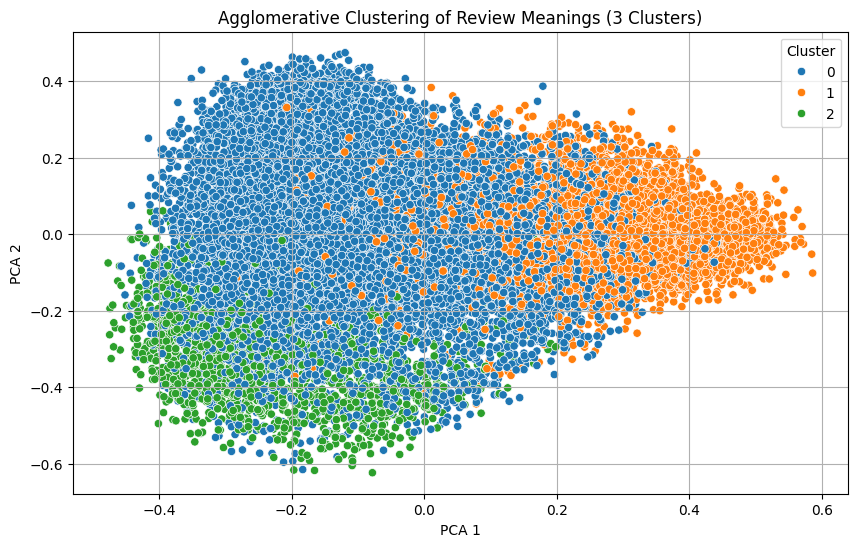


--- Agglomerative Cluster 0 ---
           good enough for trashtalking when u win
This is an easy game to get into but the skill ...
                                        pub g nuts

--- Agglomerative Cluster 1 ---
this shit is too good  (for Rac1sts)
                            Dog-Shit
                         账号被盗导致游戏被封禁

--- Agglomerative Cluster 2 ---
    Full of cheaters , play prepared to lose time.
                           this game is full cheat
full of cheaters, bugs, lack of content but hey...


In [46]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['Agglo_Cluster'] = agglo.fit_predict(X_embed)

# Reducing dimensions for plotting
X_pca = PCA(n_components=2).fit_transform(X_embed)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Ploting clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='Agglo_Cluster', data=df, palette='tab10')
plt.title("Agglomerative Clustering of Review Meanings (3 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

for c in sorted(df['Agglo_Cluster'].unique()):
    print(f"\n--- Agglomerative Cluster {c} ---")
    print(df[df['Agglo_Cluster'] == c]['text'].sample(3,random_state = 42).to_string(index=False))

<style>
.agglo-box {
  background:rgb(233, 255, 246);
  border-left: 6px solid rgb(8, 234, 189);
  padding: 1.2em 1.5em;
  border-radius: 10px;
  font-family: 'Segoe UI', sans-serif;
  box-shadow: 0 2px 5px rgba(0,0,0,0.04);
}
.agglo-title {
  font-size: 1.3em;
  font-weight: bold;
  color: #ca8a04;
  margin-bottom: 0.5em;
}
.agglo-cluster {
  margin-bottom: 1em;
  color: black;
}
.agglo-cluster h4 {
  margin: 0.2em 0;
  color: #444;
}
ul {
  margin-top: 0.4em;
  margin-bottom: 0.8em;
}
</style>

<div class="agglo-box">
  <div class="agglo-title">🔍 Interpretation of Agglomerative Clustering (3 Clusters)</div>

  <div class="agglo-cluster">
    <h4>🟦 Cluster 0 – Core Authentic Reviews</h4>
    <ul>
      <li>Contains the majority of what appear to be “legit” user reviews</li>
      <li>Includes balanced, clearly written feedback — both positive and negative</li>
      <li>Examples like “This is the best game I’ve ever played” and “straight trash” reflect honest user opinions without meme-like formatting or sarcasm</li>
    </ul>
    <p><strong>Conclusion:</strong> This cluster likely captures the <em>mainstream, authentic voice of the player base</em> — it represents the most direct expressions of user experience.</p>
  </div>

  <div class="agglo-cluster">
    <h4>🟧 Cluster 1 – Sarcasm, Rage, or Restricted Accounts</h4>
    <ul>
      <li>More focused tone — mostly negative or sarcastic sentiment</li>
      <li>Examples like “this sh*t is too good (for Rac1sts)” and “Dog-Sh*t” show aggressive or ironic phrasing</li>
      <li>Also includes reviews about account bans (“账号被盗导致游戏被封禁”) — possibly Chinese-speaking users reporting abuse or ban issues</li>
    </ul>
    <p><strong>Conclusion:</strong> This cluster captured emotionally intense reviews, sarcastic tone, and possibly more structured anger/complaints.</p>
  </div>
    <div class="agglo-cluster">
    <h4>🟩 Cluster 2 – Cheater Reports and Game Frustrations</h4>
    <ul>
      <li>Highly focused on cheating, bugs, and wasted time</li>
      <li>Common phrases: “full of cheaters”, “play prepared to lose”, “lack of content”</li>
      <li>Balanced tone: harsh but detailed critique</li>
    </ul>
    <p><strong>Conclusion:</strong> This cluster represents the <em>serious frustration group</em> — players fed up with systemic issues like cheaters and broken mechanics.</p>
  </div>
</div>


## 4 Time‑Series Forecasting – ARIMA

## 5 Explainability & Fairness – Logistic Regression + SHAP

## 6 Hyper‑parameter Tuning & Evaluation